In [1]:
from load_data import *
# from binary_architecture import *
from multiclass_architecture import *
from train_and_test import *
import pandas as pd

In [22]:
def get_images(image_random_state=0, binary=True):
    train_images, train_labels, test_images, test_labels = load_n_images(1200, random_state=image_random_state)
    if binary:
        train_labels = np.array([0 if x < 5 else 1 for x in train_labels])
        test_labels = np.array([0 if x < 5 else 1 for x in test_labels])
    return train_images, train_labels, test_images, test_labels

def one_cnn_run(args, seed, train_images, train_labels, test_images, test_labels):
    # Set seeds for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Prepare data loaders
    train_dataset = TensorDataset(torch.Tensor(train_images).unsqueeze(1), torch.Tensor(train_labels).long())
    train_loader = DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)

    test_dataset = TensorDataset(torch.Tensor(test_images).unsqueeze(1), torch.Tensor(test_labels).long())
    test_loader = DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False)

    # Instantiate models
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    encoder = Encoder(args).to(device)
    classifier = Class_out(args).to(device)
    conf_out = Conf_out(args).to(device)

    # Define loss functions and optimizer
    criterion_class = nn.CrossEntropyLoss()
    criterion_conf = nn.BCELoss()  # Binary Cross Entropy for confidence prediction
    optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()) + list(conf_out.parameters()), lr=args.learning_rate)

    # Run the CNN denoise training loop
    best_model, test_z, test_conv_flat, stats = CNN_denoise(
        encoder=encoder,
        classifier=classifier,
        conf_out=conf_out,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion_class=criterion_class,
        criterion_conf=criterion_conf,
        optimizer=optimizer,
        device=device
    )

    # Return or log the results
    results = {
        'best_model': best_model,
        'stats': stats
    }

    # one_cnn_stats = stats
    # print(one_cnn_stats)

    # Return the results
    return results, test_z, test_conv_flat

# Hyperparameters
class Args:
    latent_dim = 100 # this would cause PCA testing accuracy to go up
    train_batch_size = 32
    test_batch_size = 100
    epochs = 5
    learning_rate = 0.001

args = Args()

def one_crowd(train_images, train_labels, test_images, test_labels, loop_num=10, args=args):
    # Get the images
    best_models = []
    model_accs = []
    model_confs = []

    # Run the CNN denoise training loop
    for seed in range(loop_num):
        results, _, _ = one_cnn_run(args, seed, train_images, train_labels, test_images, test_labels)
        best_models.append(results['best_model'])
        model_accs.append(results['stats']['test_acc'])
        model_confs.append(results['stats']['test_conf'])
    return best_models, model_accs, model_confs

def crowd_stats(loop_num=10,crowd_num=10,binary=True):
    # use many image random states to generate many crowds and collect their stats
    crowd_accs = []
    crowd_confs = []
    crowd_acc_means = []
    crowd_conf_means = []
    for i in range(crowd_num):
        train_images, train_labels, test_images, test_labels = get_images(i+42, binary=binary)
        _, model_accs, model_confs = one_crowd(train_images, train_labels, test_images, test_labels, loop_num)
        crowd_accs.append(model_accs)
        crowd_confs.append(model_confs)
        crowd_acc_means.append(np.mean(model_accs))
        crowd_conf_means.append(np.mean(model_confs))
        print(f'crowd {i} done')
    return crowd_accs, crowd_confs, crowd_acc_means, crowd_conf_means

In [14]:
train_images, train_labels, test_images, test_labels = get_images(42, binary=True)
best_models, model_accs, model_confs = one_crowd(train_images, train_labels, test_images, test_labels, 1, args)

In [26]:
crowd_accs, crowd_confs, crowd_acc_means, crowd_conf_means = crowd_stats(100,5,binary=False)

crowd 0 done
crowd 1 done
crowd 2 done
crowd 3 done
crowd 4 done


##### Looking at Crowds.

In [ ]:
# get the average, std, min and max of the averages
print("Average test accuracy: ", np.mean(crowd_acc_means))
print("Average test confidence: ", np.mean(crowd_conf_means))
# stds
print("Test accuracy std: ", np.std(crowd_acc_means))
print("Test confidence std: ", np.std(crowd_conf_means))

# range
print("Test accuracy range: ", np.max(crowd_acc_means), np.min(crowd_acc_means))
print("Test confidence range: ", np.max(crowd_conf_means), np.min(crowd_conf_means))

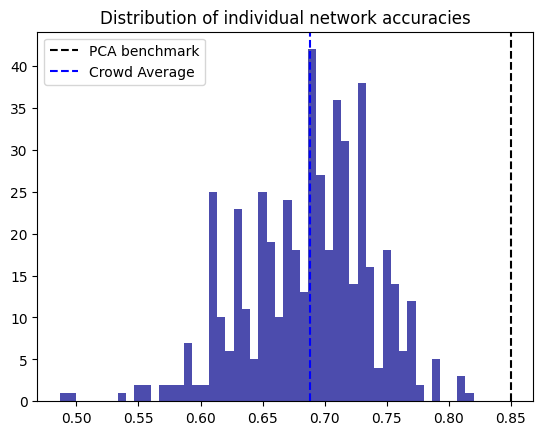

In [29]:
# probability histogram of distribution of all individual network accuracies
plt.hist(np.array(crowd_accs).flatten(), bins=50, color='darkblue', alpha=0.7)
plt.title('Distribution of individual network accuracies')
# add a x=0.78 line "PCA benchmark"
plt.axvline(x=0.85, color='black', linestyle='--', label='PCA benchmark')
# add another line "Crowd Average"
plt.axvline(x=np.mean(crowd_acc_means), color='blue', linestyle='--', label='Crowd Average')
plt.legend()
plt.savefig('crowd_accs_mutliclass.png')
plt.show()

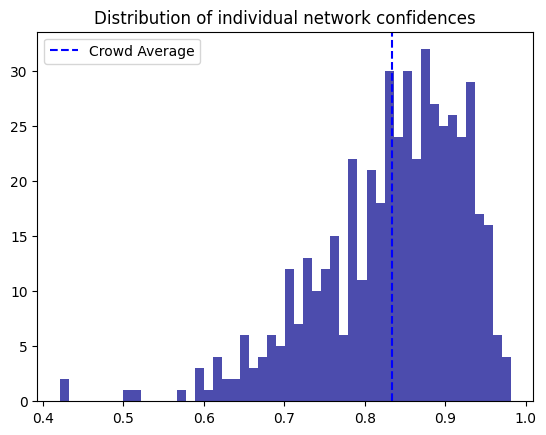

In [30]:
# probability histogram of distribution of all individual network confidences
plt.hist(np.array(crowd_confs).flatten(), bins=50, color='darkblue', alpha=0.7)
plt.title('Distribution of individual network confidences')
# add another line "Crowd Average"
plt.axvline(x=np.mean(crowd_conf_means), color='blue', linestyle='--', label='Crowd Average')
plt.legend()
plt.savefig('crowd_confs_binary_multiclass.png')
plt.show()

## Voting Methods

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def absolute_majority(models, test_loader, args, seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    votes = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Initialize and move the model to the device
    encoder = Encoder(args).to(device)
    classifier = Class_out(args).to(device)
    
    with torch.no_grad():
        for batch_images, batch_labels in test_loader:
            batch_images = batch_images.to(device)
            batch_votes = []
            
            # Collect votes from each model
            for model in models:
                # Load the weights into the models
                encoder.load_state_dict(model['encoder'])  # Load encoder parameters
                classifier.load_state_dict(model['classifier'])  # Load classifier parameters
                
                encoder.eval()
                classifier.eval()

                z, _ = encoder(batch_images, device)
                class_preds = classifier(z)
                batch_votes.append(torch.argmax(class_preds, dim=1).cpu().numpy())
            
            # Transpose to get votes per sample
            batch_votes = np.array(batch_votes).T  # Shape (batch_size, num_models)
            votes.extend(batch_votes)
    
    # Get the majority vote per sample
    votes = np.array(votes)
    majority_votes = [np.bincount(vote).argmax() for vote in votes]
    
    return majority_votes

# def relative_majority(models, model_accs, test_loader, args, loop_num):
#     votes = []
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     # Initialize and move the model to the device
#     encoder = Encoder(args).to(device)
#     classifier = Class_out(args).to(device)

#     with torch.no_grad():
#         for batch_images, batch_labels in test_loader:
#             batch_images = batch_images.to(device)
#             weighted_votes = np.zeros((batch_images.shape[0], loop_num))
            
#             # Collect weighted votes from each model
#             for i, model in enumerate(models):
#                  # Load the weights into the models
#                 encoder.load_state_dict(model['encoder'])  # Load encoder parameters
#                 classifier.load_state_dict(model['classifier'])  # Load classifier parameters
                
#                 encoder.eval()
#                 classifier.eval()

#                 z, _ = encoder(batch_images, device)
#                 class_preds = classifier(z)
                
#                 # Accumulate weighted probabilities
#                 weighted_votes += model_accs[i] * class_preds.cpu().numpy()
                
#             # Assign the class with the highest weighted vote
#             votes.extend(np.argmax(weighted_votes, axis=1))
    
#     return votes

def evaluate_ensemble(predictions, test_labels):
    correct = (predictions == test_labels).sum()
    total = len(test_labels)
    accuracy = correct / total
    return accuracy

_, _, test_images, test_labels = get_images()
test_dataset = TensorDataset(torch.Tensor(test_images).unsqueeze(1), torch.Tensor(test_labels).long())
test_loader = DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False)

In [57]:
abs_majority_preds = absolute_majority(best_models, test_loader, args)
print(f'Absolute majority ensemble accuracy: {evaluate_ensemble(abs_majority_preds, test_labels)}')

# rel_majority_preds = relative_majority(best_models, model_accs, test_loader, args, loop_num)
# print(f'Relative majority ensemble accuracy: {evaluate_ensemble(rel_majority_preds, test_labels)}')

Absolute majority ensemble accuracy: 0.8066666666666666


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# PCA-based latent space
train_images, train_labels, test_images, test_labels = get_images(42,binary=False)
loop_num = 10

train_pca, test_pca, train_reconstructed, test_reconstructed = PCA_reduction(train_images, test_images, args.latent_dim, random_seed=0)
# Logistic regression classifier for PCA-based latent space
clf_pca = LogisticRegression(max_iter=loop_num)
clf_pca.fit(train_pca, train_labels)  # Train on PCA latent space
test_preds_pca = clf_pca.predict(test_pca)  # Predict on test set
# Compute accuracy
acc_pca = accuracy_score(test_labels, test_preds_pca)
print(f"Accuracy on test set using PCA: {acc_pca * 100:.2f}%")

Accuracy on test set using PCA: 85.67%


### Failed Attempts

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

def vote_majority(X):
    # along the second axis, find the most common element
    return np.array([Counter(column).most_common(1)[0][0] for column in X.T])

# Initialize a list to store the decision trees
decision_trees = []
prediction_trees = []
prediction_trees_probs = []

for i in range(loop_num): 
    # # Create a new decision tree
    tree = DecisionTreeClassifier(max_depth=3, random_state=i, max_features=8) # change max_features according to latent_dim
    # tree = RandomForestClassifier(n_estimators=loop_num, max_depth=5, random_state=i, max_features=64)
    # Fit the decision tree on the latent representations
    training_array = train_zs[i]
    tree.fit(training_array, train_labels)
    # Append the decision tree to the list
    decision_trees.append(tree)

    # Predict the test labels using the decision tree
    testing_array = test_zs[i]
    
    prediction_tree = tree.predict(testing_array)
    prediction_trees.append(prediction_tree)

    # Predict the test labels using the decision tree and calculate the probabilities
    prediction_tree_probs = tree.predict_proba(testing_array)
    prediction_trees_probs.append(prediction_tree_probs)

prediction_trees = np.array(prediction_trees)
prediction_trees_probs = np.array(prediction_trees_probs)

# vote for the majority
rf_predictions = vote_majority(prediction_trees)
# calculate the accuracy
print(f"Testing accuracy: {accuracy_score(test_labels, rf_predictions):.4f}")
# Calculate the average probability for each class across all trees
average_probs = np.mean(prediction_trees_probs, axis=0)
# Calculate the average confidence of the predictions
average_confidences = np.max(average_probs, axis=1)
average_confidence = np.mean(average_confidences)
print(f"Average confidence of predictions: {average_confidence:.4f}")

Testing accuracy: 0.1767
Average confidence of predictions: 0.1321


In [ ]:
# do the same analysis using XGBoost

from xgboost import XGBClassifier

# Initialize a list to store the XGBoost models
xgboost_models = []
prediction_xgboost = []
prediction_xgboost_probs = []

for i in range(loop_num):
    # Create a new XGBoost model
    xgboost = XGBClassifier(n_estimators=loop_num, random_state=i, learning_rate=0.1)
    # Fit the XGBoost model on the latent representations
    training_array = train_zs[i]
    xgboost.fit(training_array, train_labels)
    # Append the XGBoost model to the list
    xgboost_models.append(xgboost)

    # Predict the test labels using the XGBoost model
    testing_array = test_zs[i]
    prediction_xgb = xgboost.predict(testing_array)
    prediction_xgboost.append(prediction_xgb)

    # Predict the test labels using the XGBoost model and calculate the probabilities
    prediction_xgb_probs = xgboost.predict_proba(testing_array)
    prediction_xgboost_probs.append(prediction_xgb_probs)

prediction_xgboost = np.array(prediction_xgboost)
prediction_xgboost_probs = np.array(prediction_xgboost_probs)

# vote for the majority
xgboost_predictions = vote_majority(prediction_xgboost)
# calculate the accuracy
print(f"Testing accuracy: {accuracy_score(test_labels, xgboost_predictions):.4f}")
# Calculate the average probability for each class across all trees
average_probs = np.mean(prediction_xgboost_probs, axis=0)
# Calculate the average confidence of the predictions
average_confidences = np.max(average_probs, axis=1)
average_confidence = np.mean(average_confidences)
print(f"Average confidence of predictions: {average_confidence:.4f}")

Testing accuracy: 0.1333
Average confidence of predictions: 0.1234
